### Importazione librerie

In [1]:
import pandas as pd
import numpy as np
import ccxt
from ta.volatility import AverageTrueRange
from ta.momentum import RSIIndicator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, r2_score
warnings.filterwarnings('ignore')

### Raccolta dati
Utilizziamo la funzione download_and_plot per scaricare i dati di Bitcoin da Bybit per il 2024 con timeframe di 1 minuto e li salviamo in un DataFrame.

In [2]:
def download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot):
    exchange_class = getattr(ccxt, market)
    exchange = exchange_class()
    exchange.load_markets()
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)
    data_frames = {}
    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su {market}.")
        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        ohlcv = []
        since = start_timestamp
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1
            time.sleep(exchange.rateLimit / 1000)
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df
    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [ ]:
# # Parametri per il download
# cryptos = ['BTC']
# market = 'bybit'
# timeframe_download = '1m'
# start_date = '2024-01-01'
# end_date = '2024-12-31'
# plot = False  # Imposta a True se vuoi visualizzare i grafici

# # Scarica i dati
# data = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot)
# btc_df = data['BTC']

# # Visualizza le prime righe per controllo
# btc_df

btc_df = pd.read_csv('Bitcoin (USDT) 2024 timeframe 1m.csv')
btc_df.set_index('timestamp', inplace=True)
btc_df.index = pd.to_datetime(btc_df.index)
btc_df

,open,high,low,close,volume
timestamp,,,,,
2024-01-01 00:00:00,42284.00,42300.00,42260.01,42300.00,15.059749
2024-01-01 00:01:00,42300.00,42321.99,42299.99,42320.28,4.240722
2024-01-01 00:02:00,42320.28,42335.79,42317.30,42322.57,5.671511
2024-01-01 00:03:00,42322.57,42370.00,42322.57,42366.50,6.801620
2024-01-01 00:04:00,42366.50,42399.68,42366.50,42399.68,6.264730
...,...,...,...,...,...
2024-12-30 23:56:00,92816.59,92878.51,92789.85,92870.74,6.900125
2024-12-30 23:57:00,92870.74,92895.11,92838.44,92844.67,6.369311
2024-12-30 23:58:00,92844.67,92845.68,92797.10,92831.16,6.396956


### Feature engineering
Calcoliamo le feature richieste: ATR, RSI, medie mobili semplici (SMA) ed esponenziali (EMA), deviazioni standard mobili, minimi e massimi mobili, sia sui prezzi che sulle variazioni percentuali. Aggiungiamo anche le derivate prima, seconda e terza.

In [8]:
def calculate_indicators(df, windows, atr_windows, rsi_windows):
    price_types = ['open', 'high', 'low', 'close']

    # Calcolo della variazione percentuale
    for price_type in price_types:
        df[f'pct_change_{price_type}'] = df[price_type].pct_change()
    
    # ATR
    for atr_window in atr_windows:
        df[f'ATR_{atr_window}'] = AverageTrueRange(df['high'], df['low'], df['close'], window=atr_window).average_true_range()

    # RSI
    for price_type in price_types:
        for rsi_window in rsi_windows:
            df[f'RSI_{price_type}_{rsi_window}'] = RSIIndicator(df[price_type], window=rsi_window).rsi()
    
    # SMA, EMA, STD, MIN, MAX
    for window in windows:
        for price_type in price_types:
            df[f'SMA_{price_type}_{window}'] = df[price_type].rolling(window=window).mean()
            df[f'EMA_{price_type}_{window}'] = df[price_type].ewm(span=window, adjust=False).mean()
            df[f'STD_{price_type}_{window}'] = df[price_type].rolling(window=window).std()
            df[f'MIN_{price_type}_{window}'] = df[price_type].rolling(window=window).min()
            df[f'MAX_{price_type}_{window}'] = df[price_type].rolling(window=window).max()
            
            # Indicatori sulle variazioni percentuali
            df[f'SMA_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).mean()
            df[f'EMA_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].ewm(span=window, adjust=False).mean()
            df[f'STD_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).std()
            df[f'MIN_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).min()
            df[f'MAX_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).max()
    
    # Calcolo delle derivate
    feature_cols = [col for col in df.columns]
    for col in feature_cols:
        df[f'{col}_diff1'] = df[col].diff()
        df[f'{col}_diff2'] = df[col].diff().diff()
        df[f'{col}_diff3'] = df[col].diff().diff().diff()
    
    return df

In [9]:
# Parametri regolabili
windows = [20, 50, 200] #[5, 20, 50, 200, 720, 1440] # Finestre per gli indicatori
atr_windows = [5, 14, 60]
rsi_windows = [5, 14, 60]

# Calcola le feature
btc_df = calculate_indicators(btc_df, windows, atr_windows, rsi_windows)

# Rimuovi i NaN generati dai calcoli
btc_df = btc_df.dropna()

# Visualizza le prime righe per controllo
btc_df

,open,high,low,close,volume,pct_change_open,pct_change_high,pct_change_low,pct_change_close,ATR_5,...,EMA_PCT_close_200_diff3,STD_PCT_close_200_diff1,STD_PCT_close_200_diff2,STD_PCT_close_200_diff3,MIN_PCT_close_200_diff1,MIN_PCT_close_200_diff2,MIN_PCT_close_200_diff3,MAX_PCT_close_200_diff1,MAX_PCT_close_200_diff2,MAX_PCT_close_200_diff3
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 03:23:00,42461.01,42461.01,42442.86,42442.86,2.123256,-0.000447,-0.000669,-0.000427,-0.000427,17.596708,...,0.000008,-5.380293e-06,-6.720369e-06,-8.910441e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 03:24:00,42442.86,42450.69,42442.86,42446.00,1.465701,-0.000427,-0.000243,0.000000,0.000074,15.643366,...,0.000005,-3.793190e-06,1.587102e-06,8.307471e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 03:25:00,42446.00,42456.80,42446.00,42453.05,0.247349,0.000074,0.000144,0.000074,0.000166,14.674693,...,-0.000004,-1.337472e-07,3.659443e-06,2.072341e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 03:26:00,42453.05,42454.17,42439.13,42439.13,3.225596,0.000166,-0.000062,-0.000162,-0.000328,14.747754,...,-0.000006,-1.253501e-07,8.397144e-09,-3.651046e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 03:27:00,42439.13,42444.00,42437.75,42442.14,11.095998,-0.000328,-0.000240,-0.000033,0.000071,13.048203,...,0.000009,-3.841145e-07,-2.587645e-07,-2.671616e-07,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:56:00,92816.59,92878.51,92789.85,92870.74,6.900125,0.000446,0.000181,0.000157,0.000583,65.775346,...,-0.000004,8.358915e-07,1.291975e-06,1.401959e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-30 23:57:00,92870.74,92895.11,92838.44,92844.67,6.369311,0.000583,0.000179,0.000524,-0.000281,63.954277,...,-0.000010,-2.233993e-06,-3.069885e-06,-4.361860e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-30 23:58:00,92844.67,92845.68,92797.10,92831.16,6.396956,-0.000281,-0.000532,-0.000445,-0.000146,60.879421,...,0.000010,-1.040317e-06,1.193676e-06,4.263561e-06,0.0,0.0,0.0,0.0,0.0,0.0


### Preparazione dei dati
Raggruppiamo i dati per giorno, li mischiamo casualmente e li dividiamo in train, validation e test sets.

In [10]:
def prepare_data(df, F, train_size=0.7, val_size=0.2, seed=42):
    """
    Prepara i dati per il training dividendo casualmente in train, validation e test set.
    
    Args:
        df (pd.DataFrame): DataFrame contenente i dati con feature e colonna 'close'.
        F (int): Numero di minuti nel futuro per il target.
        train_size (float): Percentuale di dati per il training (default: 0.7).
        val_size (float): Percentuale di dati per la validation (default: 0.2).
        seed (int): Seme per la riproducibilità (default: 42).
    
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test: Suddivisioni dei dati.
    """
    test_size = 1 - train_size - val_size  # Calcola la percentuale per il test set
    
    # Target: variazione del prezzo dopo F candele
    y = df['close'].shift(-F) - df['close']  # Variazione del prezzo come target
    
    # Rimuovi le ultime F righe dove y è NaN
    X = df.iloc[:-F]  # Feature
    y = y.iloc[:-F]   # Target
    
    # Prima suddivisione: separa train+val da test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=seed, 
        shuffle=True
    )
    
    # Calcola la proporzione per train e val rispetto al set rimanente (train+val)
    train_proportion = train_size / (train_size + val_size)
    
    # Seconda suddivisione: separa train da validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, 
        train_size=train_proportion, 
        random_state=seed, 
        shuffle=True
    )
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
# Parametri regolabili
F = 60  # Numero di candele avanti da prevedere
train_size = 0.7  # 70% dei giorni rimanenti per il train
val_size = 0.2  # 20% dei giorni rimanenti per la validation
seed = 8

# Prepara i dati (assumendo che btc_df sia il DataFrame con i dati)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(btc_df, F, train_size, val_size, seed)

# Controllo delle dimensioni
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (367736, 576), Validation: (105068, 576), Test: (52534, 576)


### Costruzione e addestramento dei modelli
Costruiamo e addestriamo un modello Random Forest e una rete neurale

#### Random forest

In [12]:
rf_model = RandomForestRegressor(
        n_estimators=100,
        criterion='squared_error',
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features='sqrt',
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=42,
        verbose=2,
        warm_start=False,
        ccp_alpha=0.0,
        max_samples=None,
    )

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  8.1min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s


R^2 (test):  0.1095
RMSE (test): 359.5130

Feature Importances (valore percentuale):


,feature,importance_pct
133,MAX_PCT_low_200,1.775393
81,STD_PCT_high_50,1.687743
93,MAX_PCT_low_50,1.471559
121,STD_PCT_high_200,1.344765
11,ATR_60,1.299383
...,...,...
420,MIN_PCT_low_50_diff1,0.000021
514,MAX_PCT_high_200_diff2,0.000015
484,MAX_PCT_open_200_diff2,0.000011
573,MAX_PCT_close_200_diff1,0.000007


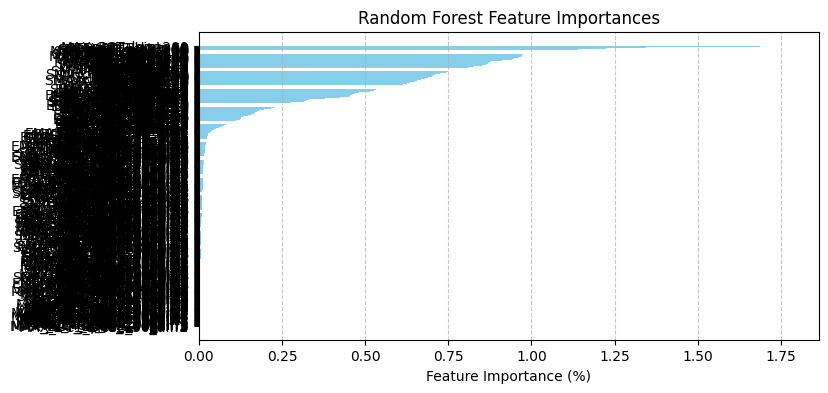

In [13]:
# Metriche di valutazione
r2 = r2_score(y_test, rf_pred)
rmse = mean_squared_error(y_test, rf_pred, squared=False)

print(f"R^2 (test):  {r2:.4f}")
print(f"RMSE (test): {rmse:.4f}")

# Feature importances
importances = rf_model.feature_importances_
importances_pct = 100.0 * (importances / importances.sum())

feats_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance_pct': importances_pct
}).sort_values('importance_pct', ascending=True)

print("\nFeature Importances (valore percentuale):")
display(feats_imp.sort_values('importance_pct', ascending=False))

# Plot orizzontale delle importanze (percentuali)
plt.figure(figsize=(8, 4))
plt.barh(feats_imp['feature'], feats_imp['importance_pct'], color='skyblue')
plt.xlabel('Feature Importance (%)')
plt.title('Random Forest Feature Importances')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [14]:
np.mean(np.sign(rf_pred) == np.sign(y_test))

np.float64(0.5408497354094491)

#### Rete neurale

In [15]:
def train_neural_network_regressor(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    network_width: int = 64,
    network_depth: int = 3,
    activation_function: str = 'relu',
    patience: int = 10,
    epochs: int = 100,
    batch_size: int = 32,
    monitor: str = 'val_loss',
    loss: str = 'mse'
):
    """
    Allena una rete neurale per predire un valore continuo (target) a partire dalle feature.
    I dati di train, validation e test sono forniti come input già preparati.

    Parametri
    ----------
    X_train : pd.DataFrame
        Feature del training set.
    y_train : pd.Series
        Target del training set.
    X_val : pd.DataFrame
        Feature del validation set.
    y_val : pd.Series
        Target del validation set.
    X_test : pd.DataFrame
        Feature del test set.
    y_test : pd.Series
        Target del test set.
    network_width : int, default 64
        Numero di neuroni in ogni strato hidden.
    network_depth : int, default 3
        Numero di strati hidden.
    activation_function : str, default 'relu'
        Funzione di attivazione da usare nei layer hidden.
    patience : int, default 10
        Numero di epoche da attendere prima di fermare l’allenamento (early stopping).
    epochs : int, default 100
        Numero massimo di epoche per l’allenamento.
    batch_size : int, default 32
        Dimensione del batch per l’allenamento.
    monitor : str, default 'val_loss'
        Metrica da monitorare per l'early stopping.
    loss : str, default 'mse'
        Funzione di loss da usare.

    Ritorna
    -------
    model : tf.keras.Model
        Il modello neurale addestrato.
    history : tf.keras.callbacks.History
        L’oggetto history con le metriche di training.
    metrics_dict : dict
        Dizionario con MAE, MAPE e loss su train, validation e test.
    """
    # Conversione a NumPy array per Keras
    X_train_np = X_train.values
    y_train_np = y_train.values
    X_val_np = X_val.values
    y_val_np = y_val.values
    X_test_np = X_test.values
    y_test_np = y_test.values

    # Costruzione del modello
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train_np.shape[1],)))
    for _ in range(network_depth):
        model.add(Dense(network_width, activation=activation_function))
    # Output: 1 neurone con attivazione lineare per regressione
    model.add(Dense(1, activation='linear'))

    # Compilazione del modello
    model.compile(optimizer='adam', loss=loss, metrics=['mae', 'mape'])

    # Configurazione dell'early stopping
    early_stop = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

    # Addestramento del modello
    history = model.fit(
        X_train_np, y_train_np,
        validation_data=(X_val_np, y_val_np),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    # Valutazione sui tre set
    train_loss, train_mae, train_mape = model.evaluate(X_train_np, y_train_np, verbose=0)
    val_loss, val_mae, val_mape = model.evaluate(X_val_np, y_val_np, verbose=0)
    test_loss, test_mae, test_mape = model.evaluate(X_test_np, y_test_np, verbose=0)

    # Creazione del dizionario delle metriche
    metrics_dict = {
        'train_loss': train_loss,
        'train_mae': train_mae,
        'train_mape': train_mape,
        'val_loss': val_loss,
        'val_mae': val_mae,
        'val_mape': val_mape,
        'test_loss': test_loss,
        'test_mae': test_mae,
        'test_mape': test_mape
    }

    # Grafici di training
    epochs_range = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(18, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    # MAE
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history.history['mae'], label='Train MAE')
    plt.plot(epochs_range, history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    # MAPE
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history.history['mape'], label='Train MAPE')
    plt.plot(epochs_range, history.history['val_mape'], label='Validation MAPE')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.title('MAPE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("Metriche finali:")
    print(metrics_dict)

    return model, history, metrics_dict

Epoch 1/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 383s 33ms/step - loss: 20061254.0000 - mae: 515.5060 - mape: 215739424.0000 - val_loss: 142916.5312 - val_mae: 239.4073 - val_mape: 624696.9375
Epoch 2/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 388s 34ms/step - loss: 224918.8906 - mae: 247.1525 - mape: 1657775.0000 - val_loss: 142931.8594 - val_mae: 239.4166 - val_mape: 403352.4688
Epoch 3/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 381s 33ms/step - loss: 142675.2031 - mae: 240.5355 - mape: 1007917.4375 - val_loss: 142918.5625 - val_mae: 239.4082 - val_mape: 568006.3125
Epoch 4/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 366s 32ms/step - loss: 141653.9844 - mae: 239.8095 - mape: 631851.3750 - val_loss: 142915.1094 - val_mae: 239.4101 - val_mape: 787520.1875
Epoch 5/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 365s 32ms/step - loss: 143305.4062 - mae: 240.4756 - mape: 828643.3750 - val_loss: 142920.7969 - val_mae: 239.4098 - val_mape: 500390.7500
Epoch 6/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 365s 32ms/step -

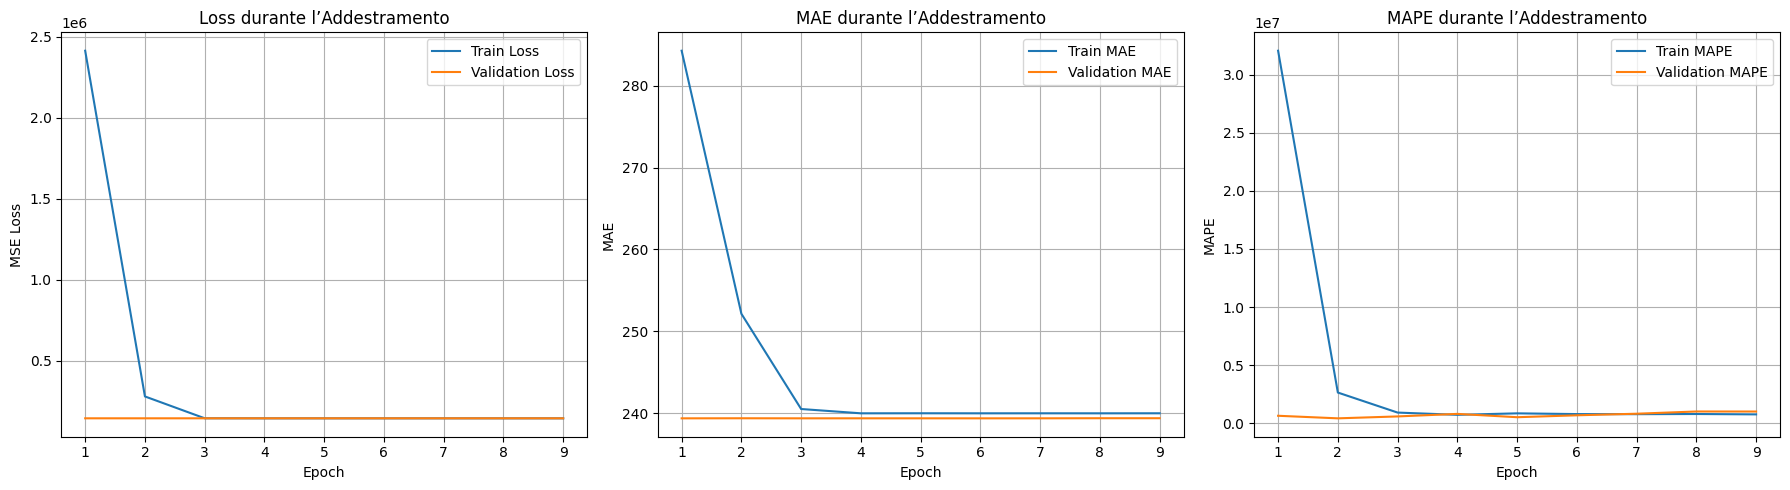

Metriche finali:
{'train_loss': 142732.46875, 'train_mae': 240.02024841308594, 'train_mape': 882605.875, 'val_loss': 142915.109375, 'val_mae': 239.41006469726562, 'val_mape': 787520.1875, 'test_loss': 145142.265625, 'test_mae': 240.67706298828125, 'test_mape': 363533.28125}


In [16]:
model, history, metrics_dict = train_neural_network_regressor(
    X_train, y_train, X_val, y_val, X_test, y_test,
    network_width=1024,
    network_depth=3,
    activation_function='relu',
    patience=5,
    epochs=10000,
    batch_size=32,
    monitor='val_loss',
    loss='mse'
)

In [17]:
# Ottieni le predizioni sul test set
predicted_change = model.predict(X_test)
nn_pred = predicted_change.flatten()
predicted_price = X_test['close'] + nn_pred

1642/1642 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


In [18]:
# Accuratezza direzionale
np.mean(np.sign(nn_pred) == np.sign(y_test))

np.float64(0.5091940457608406)

#### LSTM

In [19]:
def create_sequences(X, y, lookback, forecast_horizon=1):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X) - forecast_horizon):
        X_seq.append(X.iloc[i - lookback:i].values)
        y_seq.append(y.iloc[i + forecast_horizon])
    return np.array(X_seq), np.array(y_seq)

In [20]:
def train_lstm_model(
    X_train, y_train, X_val, y_val, X_test, y_test,
    lookback=10,              # Finestra temporale di input
    forecast_horizon=1,       # Orizzonte di previsione
    lstm_units=50,            # Numero di unità nel layer LSTM
    num_layers=1,             # Numero di layer LSTM
    dropout_rate=0.2,         # Percentuale di dropout
    dense_units=10,           # Unità nel layer denso aggiuntivo (opzionale)
    use_bidirectional=False,  # Usa LSTM bidirezionale
    activation='tanh',        # Funzione di attivazione per LSTM
    recurrent_activation='sigmoid',  # Attivazione ricorrente
    epochs=100,               # Numero massimo di epoche
    batch_size=32,            # Dimensione del batch
    learning_rate=0.001,      # Tasso di apprendimento
    patience=10,              # Pazienza per early stopping
    optimizer='adam',         # Ottimizzatore
    loss_function='mse'       # Funzione di perdita
):
    # Creare le sequenze per train, validation e test
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, lookback, forecast_horizon)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, lookback, forecast_horizon)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, lookback, forecast_horizon)
    
    # Costruire il modello LSTM
    model = Sequential()
    
    # Aggiungere layer LSTM
    for i in range(num_layers):
        if i == 0:
            # Primo layer (specifica input_shape)
            if use_bidirectional:
                model.add(Bidirectional(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(num_layers > 1),
                    input_shape=(lookback, X_train.shape[1])
                )))
            else:
                model.add(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(num_layers > 1),
                    input_shape=(lookback, X_train.shape[1])
                ))
        else:
            # Layer successivi
            if use_bidirectional:
                model.add(Bidirectional(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(i < num_layers - 1)
                )))
            else:
                model.add(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(i < num_layers - 1)
                ))
    
    # Aggiungere dropout
    model.add(Dropout(dropout_rate))
    
    # Aggiungere un layer denso opzionale
    if dense_units > 0:
        model.add(Dense(units=dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Layer di output
    model.add(Dense(1))  # Per regressione (un valore continuo)

    # Configurare l'ottimizzatore
    if optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = optimizer  # Permette di passare un ottimizzatore personalizzato

    # Compilare il modello
    model.compile(optimizer=opt, loss=loss_function)

    # Configurare l'early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Addestrare il modello
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=2
    )

    # Predizioni sul test set
    lstm_pred = model.predict(X_test_seq).flatten()

    # Calcolare le metriche
    lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_pred))
    lstm_mae = mean_absolute_error(y_test_seq, lstm_pred)

    print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")

    return model, history, lstm_pred, y_test_seq, lstm_rmse, lstm_mae

In [21]:
# Parametri per l'LSTM
lookback = 10
forecast_horizon = 5
lstm_units = 50
num_layers = 1
dropout_rate = 0.2
dense_units = 10
use_bidirectional = False
activation = 'tanh'
recurrent_activation = 'sigmoid'
epochs = 100
batch_size = 32
learning_rate = 0.001
patience = 10
optimizer = 'adam'
loss_function = 'mse'

# Addestrare l'LSTM
lstm_model, lstm_history, lstm_pred, y_test_seq, lstm_rmse, lstm_mae = train_lstm_model(
    X_train, y_train, X_val, y_val, X_test, y_test,
    lookback=lookback,
    forecast_horizon=forecast_horizon,
    lstm_units=lstm_units,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    dense_units=dense_units,
    use_bidirectional=use_bidirectional,
    activation=activation,
    recurrent_activation=recurrent_activation,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    patience=patience,
    optimizer=optimizer,
    loss_function=loss_function
)

Epoch 1/100
11492/11492 - 650s - 57ms/step - loss: 142741.2500 - val_loss: 142926.5938
Epoch 2/100
11492/11492 - 274s - 24ms/step - loss: 142734.6562 - val_loss: 142929.0625
Epoch 3/100
11492/11492 - 157s - 14ms/step - loss: 142740.5938 - val_loss: 142928.7188
Epoch 4/100
11492/11492 - 118s - 10ms/step - loss: 142734.6406 - val_loss: 142925.3906
Epoch 5/100
11492/11492 - 118s - 10ms/step - loss: 142732.1562 - val_loss: 142926.1094
Epoch 6/100
11492/11492 - 136s - 12ms/step - loss: 142736.1562 - val_loss: 142930.5469
Epoch 7/100
11492/11492 - 126s - 11ms/step - loss: 142736.8125 - val_loss: 142925.8125
Epoch 8/100
11492/11492 - 131s - 11ms/step - loss: 142736.5312 - val_loss: 142928.3750
Epoch 9/100
11492/11492 - 119s - 10ms/step - loss: 142736.2188 - val_loss: 142926.0312
Epoch 10/100
11492/11492 - 149s - 13ms/step - loss: 142735.1719 - val_loss: 142925.1719
Epoch 11/100
11492/11492 - 120s - 10ms/step - loss: 142736.7656 - val_loss: 142927.2500
Epoch 12/100
11492/11492 - 141s - 12ms/st

In [22]:
# Accuratezza direzionale
np.mean(np.sign(lstm_pred) == np.sign(y_test))

ValueError: ('Lengths must match to compare', (52534,), (52519,))

### Valutazione dei modelli
Valutiamo le performance dei modelli usando RMSE e MAE.

In [23]:
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")
    return rmse, mae, mape

# Valutazione
rf_rmse, rf_mae, rf_mape = evaluate(y_test, rf_pred, "Random Forest")
nn_rmse, nn_mae, nn_mape = evaluate(y_test, nn_pred, "Neural Network")
lstm_rmse, lstm_mae, lstm_mape = evaluate(y_test_seq, lstm_pred, "LSTM")

Random Forest - RMSE: 359.5130, MAE: 232.7762, MAPE: 1842905126795.1851
Neural Network - RMSE: 380.9754, MAE: 240.6770, MAPE: 1636644485854.3389
LSTM - RMSE: 381.0048, MAE: 240.6987, MAPE: 1619956675781.2083
